# Weighting and Aggregating

This notebook will take a look at a few methods for weigthing and aggregating our final data. These include:
- Weighting by PCA and Factor Analysis
- Weighting by Unobserved Component Analysis
- Weighting by Data Envelopment Analysis
- Additive Aggregation
- Geometric Aggregation

Before beginning, we'll need to read in our data, impute missing values, and normalize it. We will do the following:
- Impute costa_km with zeroes, and all other missing variables with median values
- Normalize the data using ranking

I'll read in the data, impute, normalize, and then break it down into year for the rest of the analysis.

### 1) Reading in Data, Imputing, Normalizing, and Year Breakdown

In [158]:
import missing_data_code as mdc
import exploration_pca_ca as epc
import normalization as norm
import jellyfish
import importlib
importlib.reload(mdc)
importlib.reload(epc)
importlib.reload(norm)

<module 'normalization' from '/Users/mariomoreno/Desktop/ML Projects/Mexico OC/normalization.py'>

Reading in the data using mdc code

In [142]:
df = mdc.reading_in('data/Mexico_Final.xlsx')

Imputing data using mdc code, including imputing 'costa_km' with zeores and all other missing variables with the median.

In [143]:
zero = mdc.impute_zero(df, {'costa_km':0})

In [144]:
cols = mdc.find_missing_cols(zero)
cols_impute = []
for c in cols:
    cols_impute.append(c[0])
working_df = mdc.single_imputation(zero, 'median', cols_impute)

Turning all our population dependent variables into per 100,000 in order to control for population differences among the states

In [145]:
# per 100,000 calculation
working_df.iloc[:,2:24] = (working_df.iloc[:,2:24].div(working_df.iloc[:,-1], axis=0)) *100000
del working_df['pop']
working_df.head()

,entidad,year,alumnos_inscritos_hs,hombres_inscritos_hs,mujeres_inscritas_hs,maestros_hs,escuelas_hs,convenios_trabajo_no_juicio,conflictos_trabajo,emplazamientos_huelga,...,prod_cobre_t,prod_zinc_t,prod_coque_t,prod_fierropellets_t,prod_azufre_t,prod_barita_t,prod_fluorita_t,altitud,costa_km,municipios
0,Aguascalientes,2010,3355.865217,1609.818471,1746.046746,228.050648,12.042278,225.625467,270.867638,27.178753,...,0.0,0.0,0.0,3883423.0,0.0,0.0,0.0,1870,0.0,11
1,Baja California,2010,3337.340764,1664.949270,1672.391493,192.009347,8.403510,72.623691,290.029623,100.501017,...,0.0,0.0,0.0,3883423.0,0.0,0.0,0.0,3,1493.0,5
2,Baja California Sur,2010,3578.575651,1813.378981,1765.196670,244.452107,11.699219,193.191054,255.535578,45.565380,...,0.0,0.0,0.0,3883423.0,0.0,0.0,0.0,10,2131.0,5
3,Campeche,2010,3388.120902,1714.855267,1673.265635,236.033114,12.668106,403.108705,140.902806,17.209503,...,0.0,0.0,0.0,3883423.0,0.0,0.0,0.0,10,425.0,11
4,Coahuila de Zaragoza,2010,2967.384756,1488.023776,1479.360980,223.543249,11.861919,838.637648,282.780951,19.590138,...,0.0,0.0,1648709.0,2567865.0,0.0,22161.0,121833.0,1700,0.0,38


Cleaning up the state titles in the data, since they have crazy spaces before and after.

In [146]:
replacing = {'Aguascalientes':1, 'Baja California':2, 'Baja California Sur':3, 'Campeche':4, 'Coahuila de Zaragoza':5, 'Colima':6, 'Chiapas':7, 'Chihuahua':8, 'Ciudad de México /b':9, 'Durango':10, 'Guanajuato':11, 'Guerrero':12, 'Hidalgo':13, 'Jalisco':14, 'México':15, 'Michoacán de Ocampo':16, 'Morelos':17, 'Nayarit':18, 'Nuevo León':19, 'Oaxaca':20, 'Puebla':21, 'Querétaro':22, 'Quintana Roo':23, 'San Luis Potosí':24, 'Sinaloa':25, 'Sonora':26, 'Tabasco':27, 'Tamaulipas':28, 'Tlaxcala':29, 'Veracruz de Ignaxio de la Llave':30, 'Yucatán':31, 'Zacatecas':32}

new_col = []
for c in working_df['entidad']:
    for state, rep in replacing.items():
        if jellyfish.jaro_distance(c.strip(), state) > 0.95:
            new_col.append(state)

In [147]:
import pandas as pd
working_df['entidad'] = pd.Series(new_col)
working_df.head()

,entidad,year,alumnos_inscritos_hs,hombres_inscritos_hs,mujeres_inscritas_hs,maestros_hs,escuelas_hs,convenios_trabajo_no_juicio,conflictos_trabajo,emplazamientos_huelga,...,prod_cobre_t,prod_zinc_t,prod_coque_t,prod_fierropellets_t,prod_azufre_t,prod_barita_t,prod_fluorita_t,altitud,costa_km,municipios
0,Aguascalientes,2010,3355.865217,1609.818471,1746.046746,228.050648,12.042278,225.625467,270.867638,27.178753,...,0.0,0.0,0.0,3883423.0,0.0,0.0,0.0,1870,0.0,11
1,Baja California,2010,3337.340764,1664.949270,1672.391493,192.009347,8.403510,72.623691,290.029623,100.501017,...,0.0,0.0,0.0,3883423.0,0.0,0.0,0.0,3,1493.0,5
2,Baja California Sur,2010,3578.575651,1813.378981,1765.196670,244.452107,11.699219,193.191054,255.535578,45.565380,...,0.0,0.0,0.0,3883423.0,0.0,0.0,0.0,10,2131.0,5
3,Campeche,2010,3388.120902,1714.855267,1673.265635,236.033114,12.668106,403.108705,140.902806,17.209503,...,0.0,0.0,0.0,3883423.0,0.0,0.0,0.0,10,425.0,11
4,Coahuila de Zaragoza,2010,2967.384756,1488.023776,1479.360980,223.543249,11.861919,838.637648,282.780951,19.590138,...,0.0,0.0,1648709.0,2567865.0,0.0,22161.0,121833.0,1700,0.0,38


Deleting all unnecessary columns and turning metal production and costa variables into binary

In [148]:
to_delete = []
for c in working_df:
    if 'hs' in c or 'mun' in c:
        to_delete.append(c)

In [149]:
to_binary = []
for c in working_df:
    if 'prod' in c or 'costa' in c:
        to_binary.append(c)

In [150]:
pre_features = epc.clean_data(working_df, [], 0, to_binary, to_delete)

### 2) Principal Components and Factor Analysis Weights

Typically, finding weights through PCA and FA entails several steps:
- Check correlations within the underlying data to make sure that they're strong enough to support a robust PCA analysis.
- Identify the principal components that represent the data, which for a factor analysis, consist of PCA vectors that 1) have eigenvalues > 1; 2) contribute more than 10% explanation of overall variance; 3) cumulatively explain at least 60% of the data.
- Determine the factor loadings

MORE TO COME...

First step before all else is to get the dataframes we need into a list that consists of:
- **df_ranked**: a dataframe for every year, normalized with rankings, that has a normal index
- **new**: a dataframe for every year, normalized with rankings, that has a multi-index of entidad and year
- **pca**: a principal components object for every year
- **y_pca**: the principal components vectors for every year that will make up the new pca dataframes down the road
- **name**: the year corresponding to all the previous entries

In [151]:
years = [2010, 2011, 2012, 2013, 2014, 2015, 2016]
dfs = []
for year in years:
    df_ranked = norm.ranking(pre_features[pre_features['year']==year].reset_index(drop=True))
    new = norm.ranking(df_ranked.set_index(['entidad', 'year'])).astype('int64')
    pca, y_pca = epc.pca(new, 5)
    name = str(year)
    dfs.append((df_ranked, new, pca, y_pca, name))

#### Checking correlations

2010


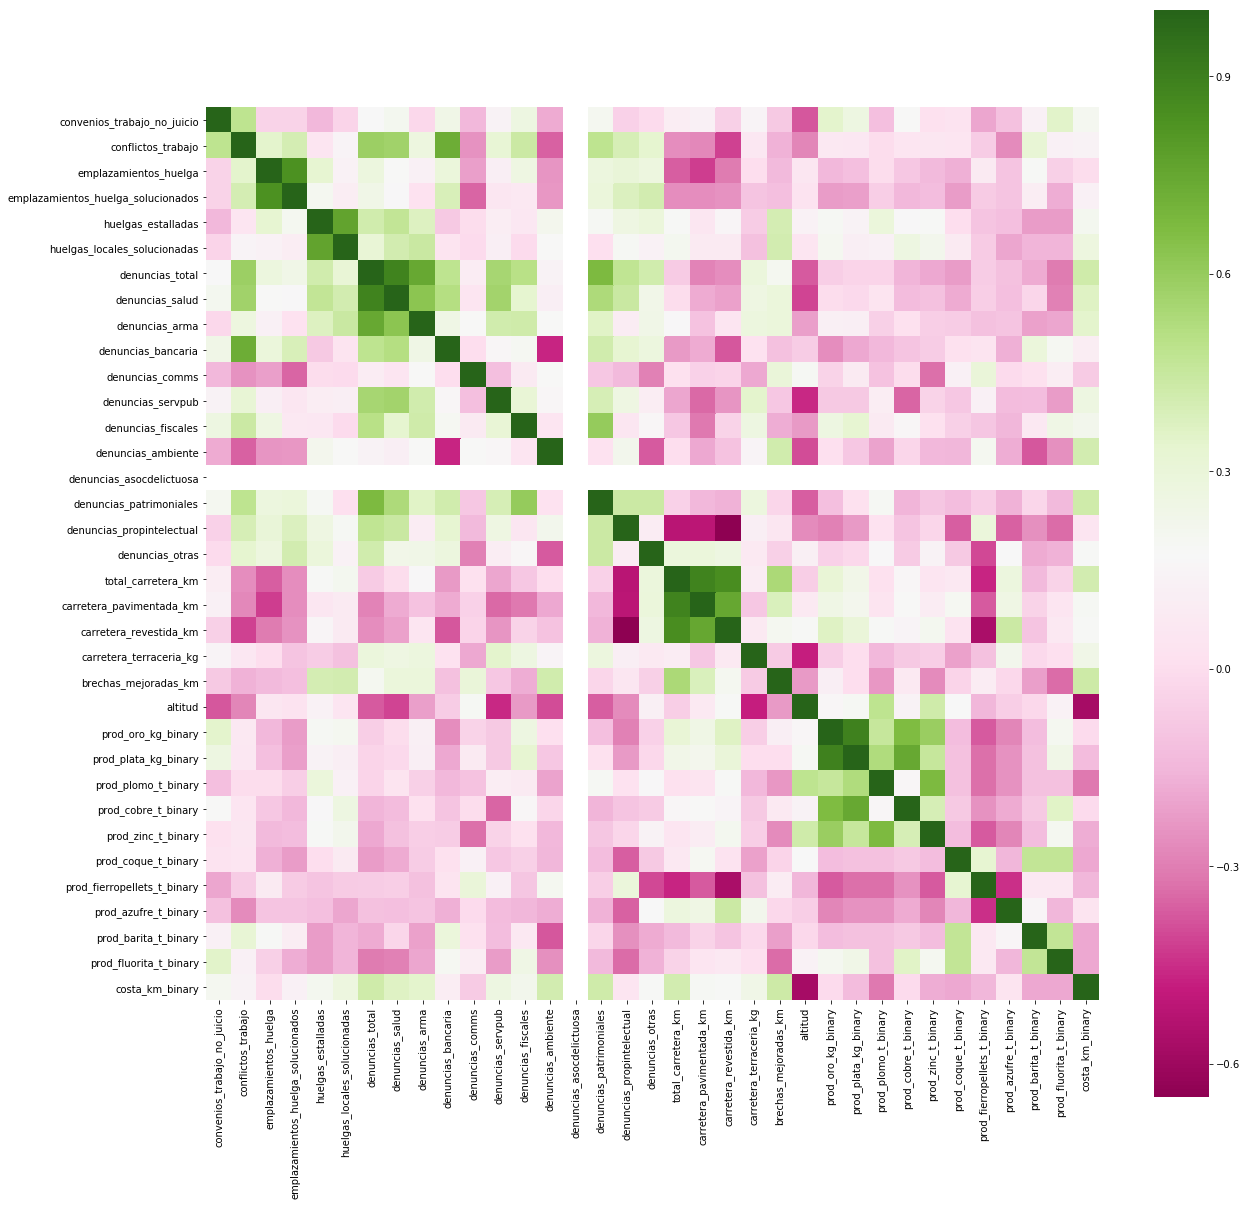

2011


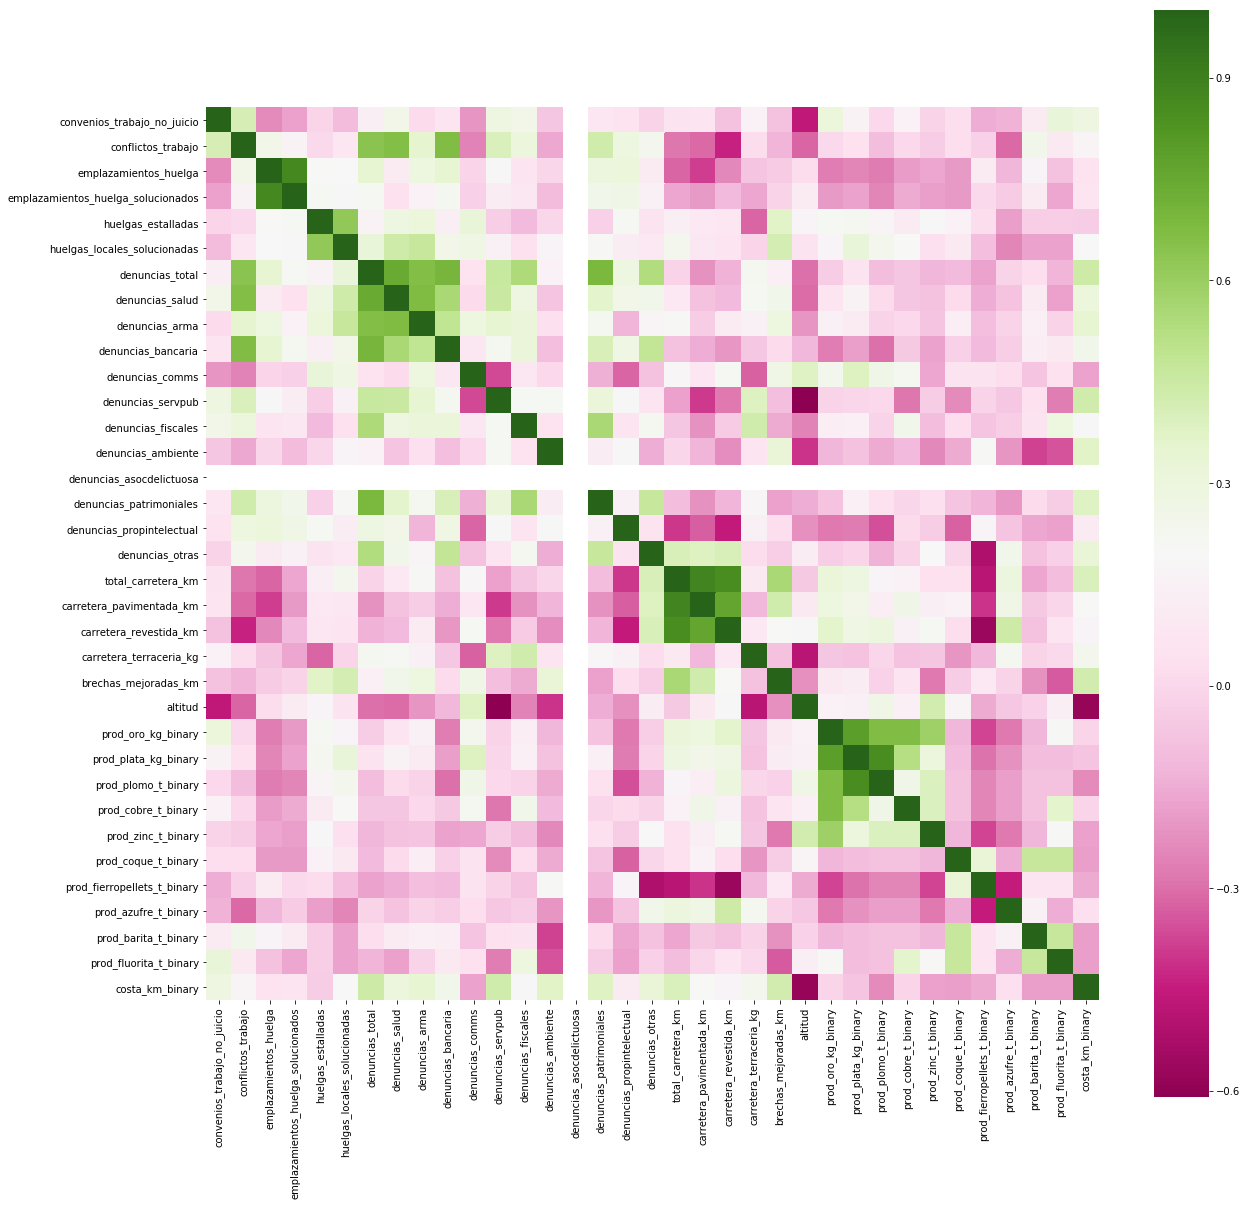

2012


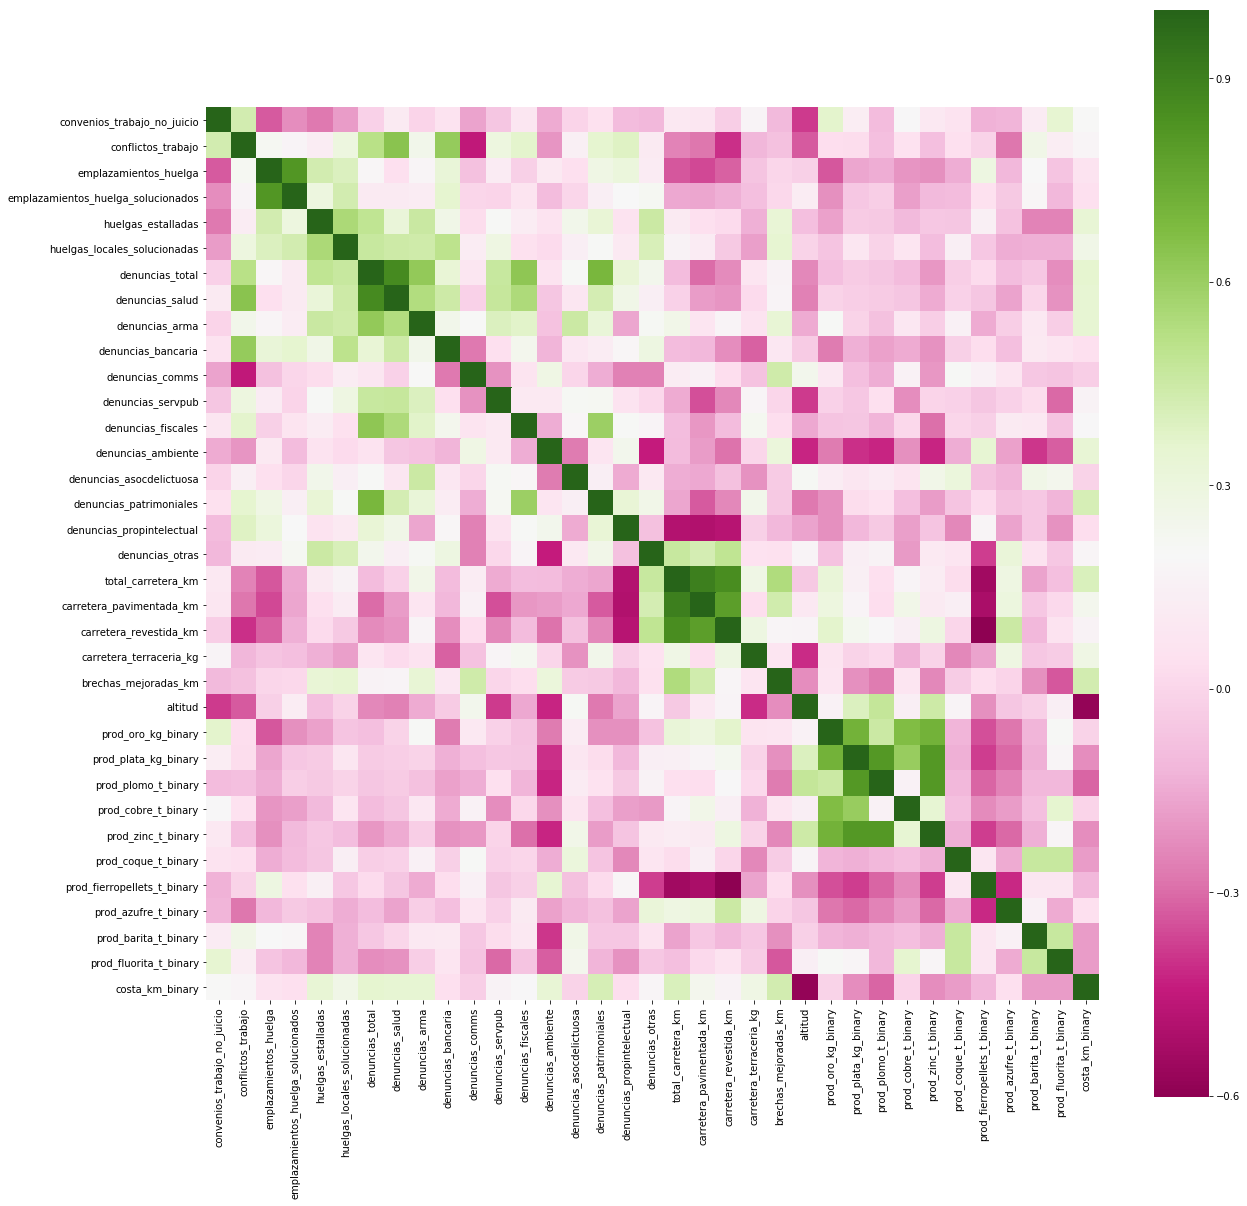

2013


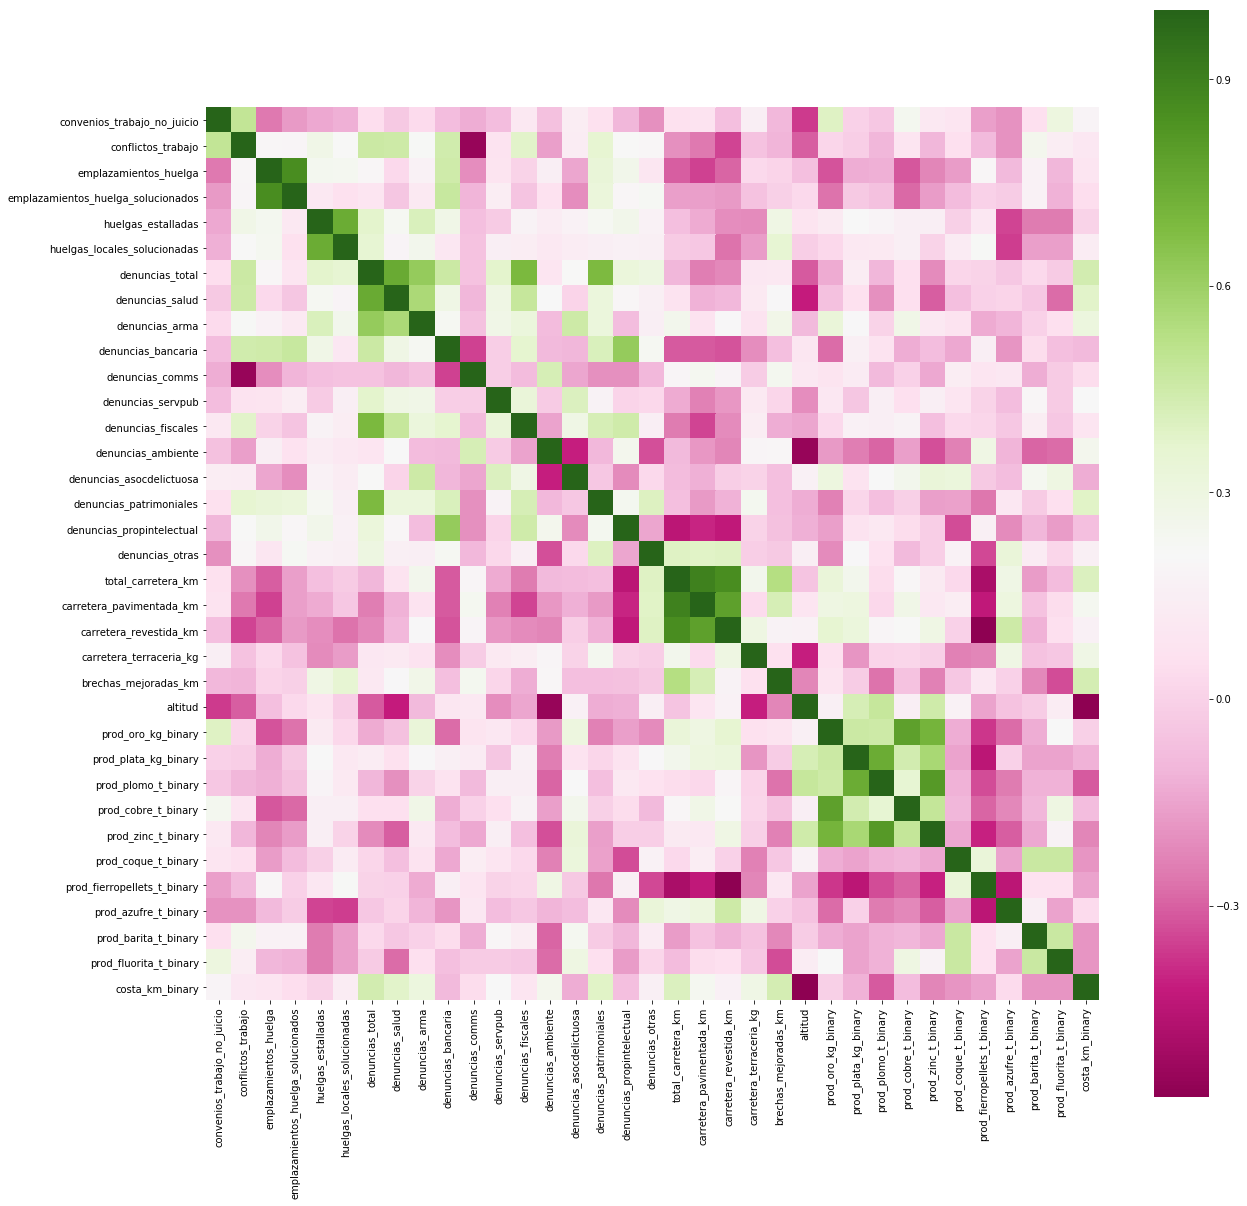

2014


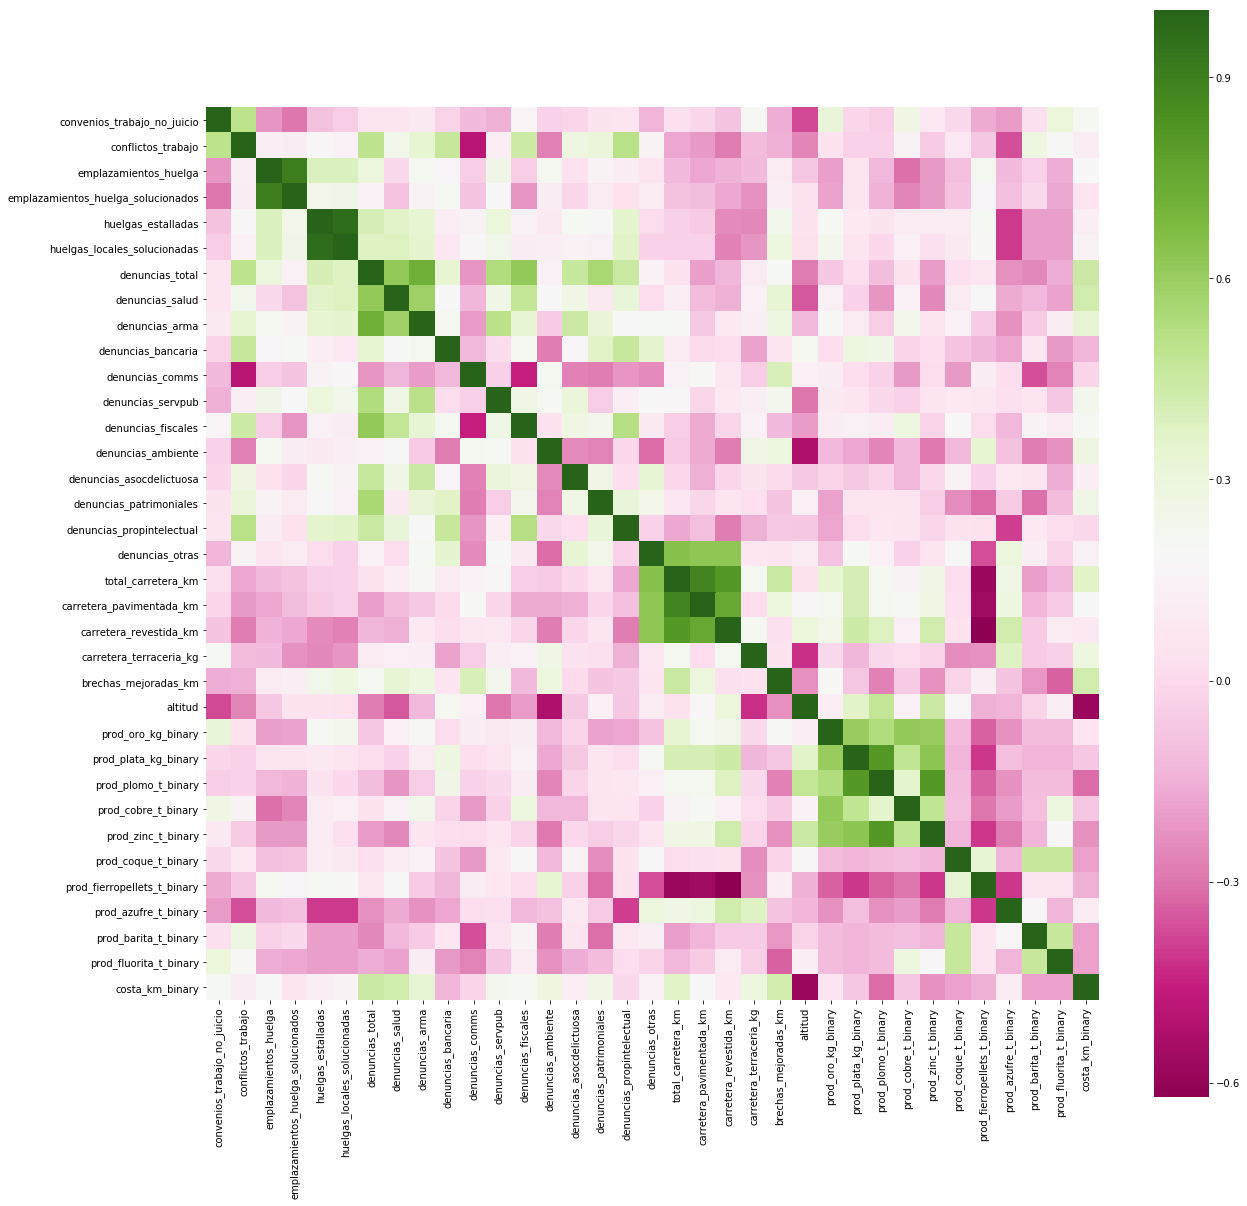

2015


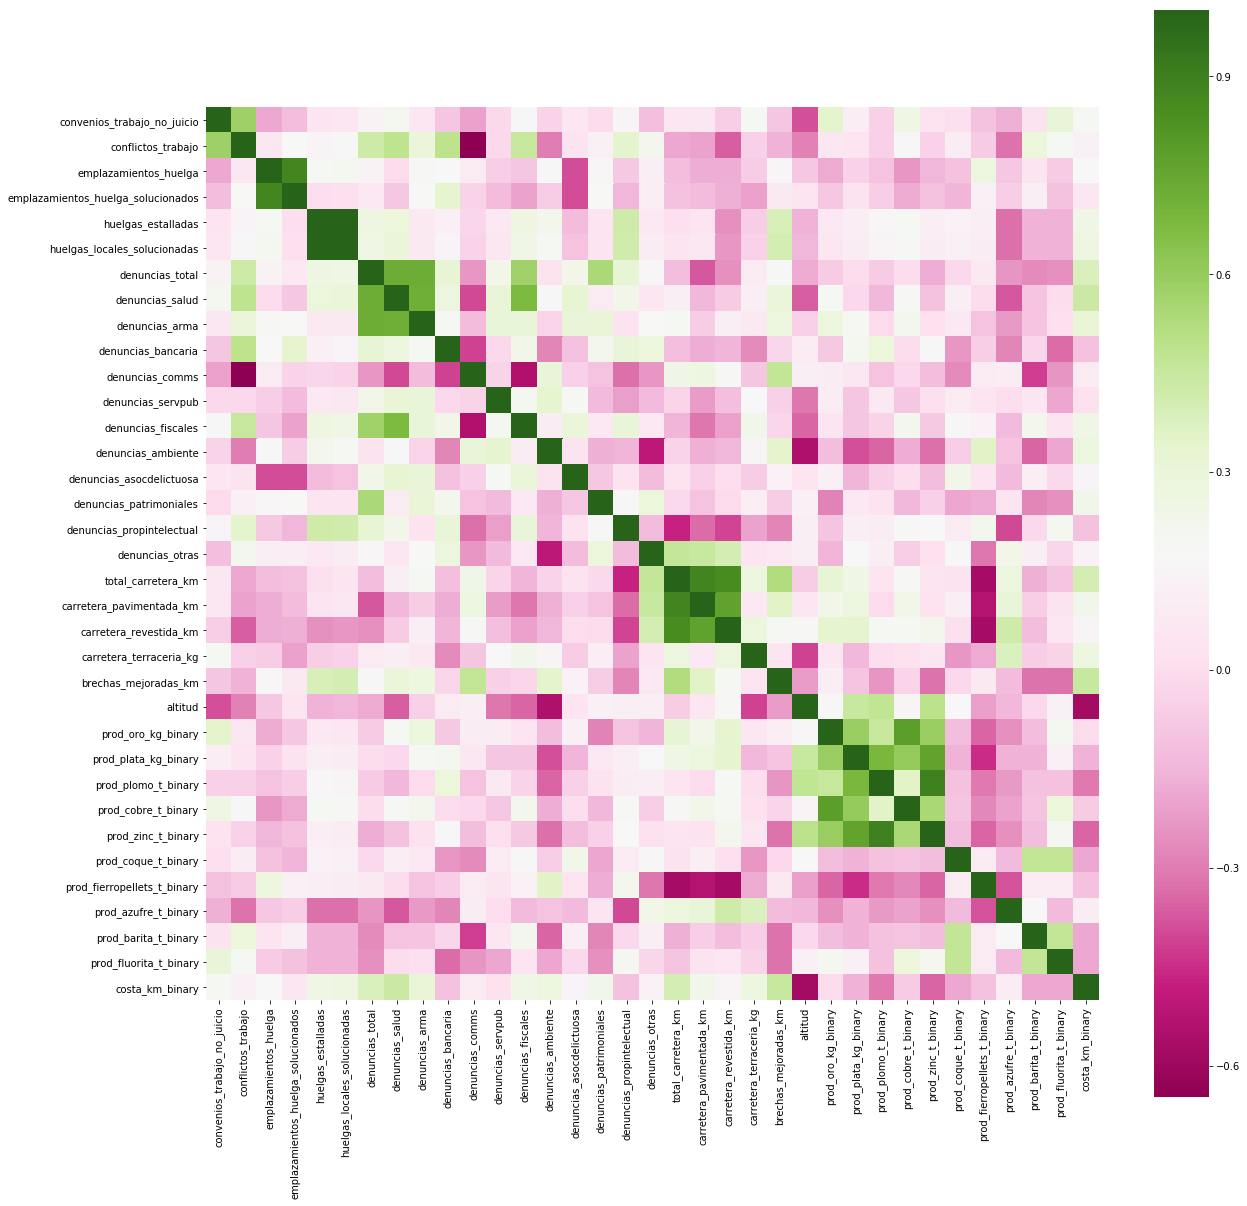

2016


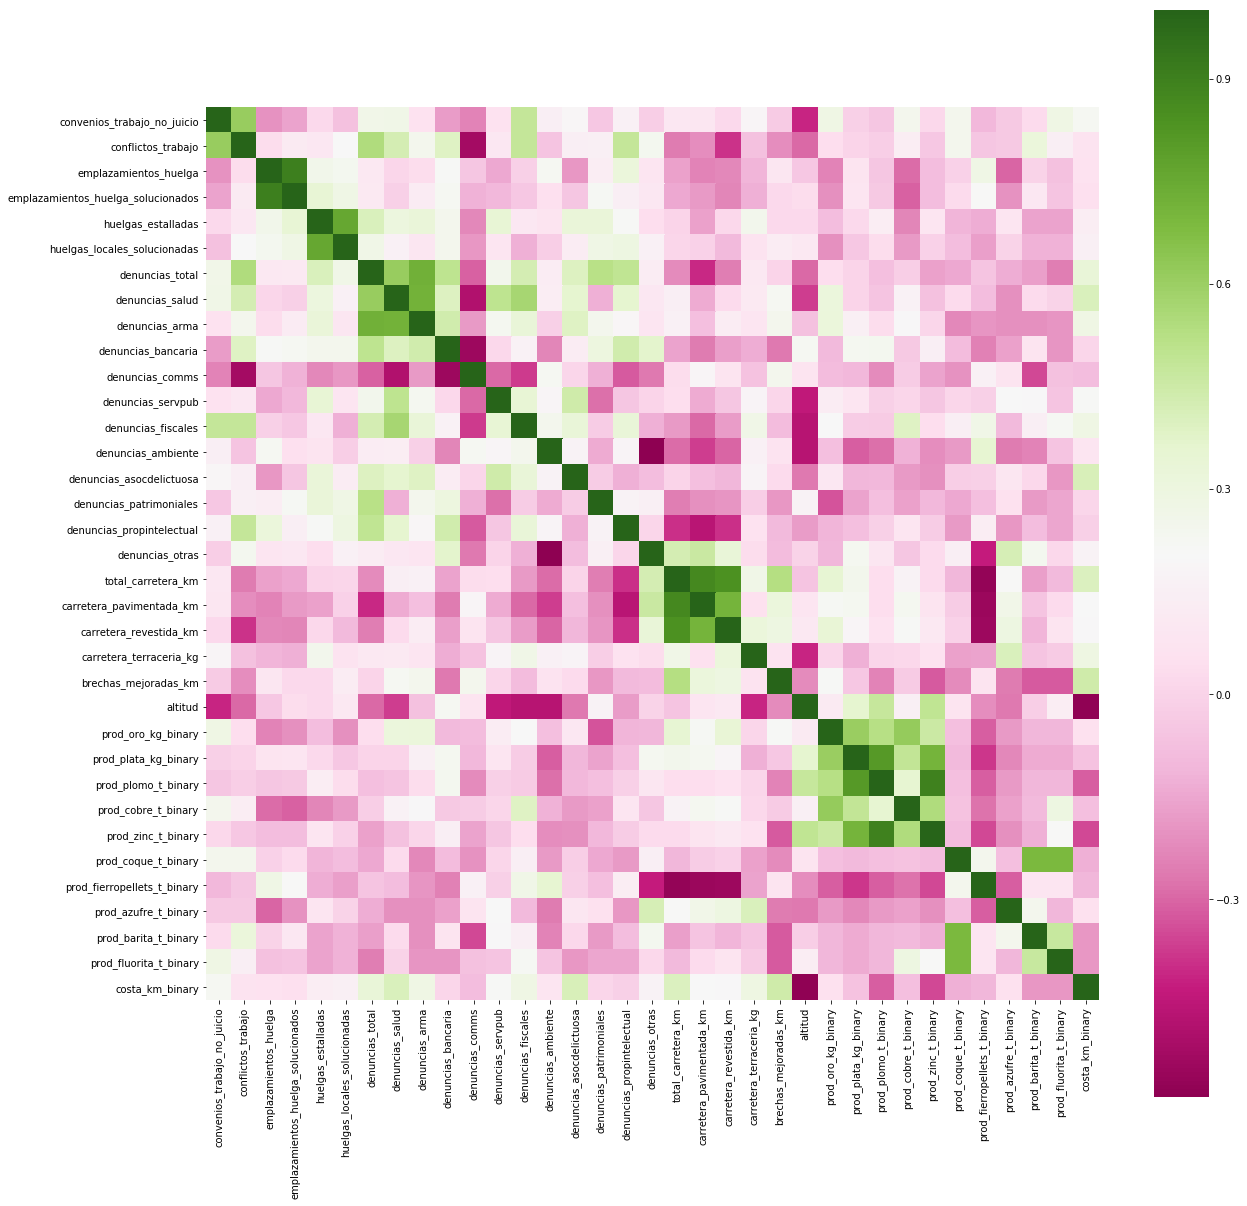

In [152]:
for df in dfs:
    print(df[4])
    epc.explore_potential_correlations(df[1])

We've got some decent correlations across all different years. Generally speaking, the metal production variables (especially oro, plata, plomo, cobre, zinc) correlate positively, as do the carretera variables, some of the denuncias variables (total, salud, arma), and some of the labor variables.

This should be ok to do a PCA analysis on. 

#### Factors chosen must account for 10% individually and 60% collectively

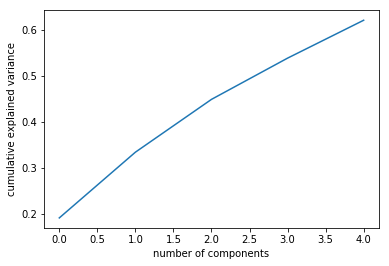

Variance explained for first 5 components in 2010
[19.04503505 33.34731087 44.84047725 53.81444422 62.06065708]



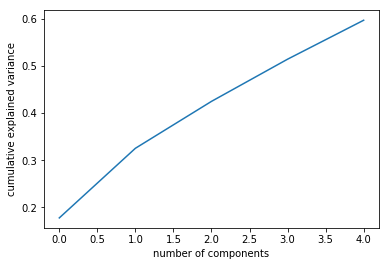

Variance explained for first 5 components in 2011
[17.75567706 32.53431578 42.49267393 51.44503911 59.71323677]



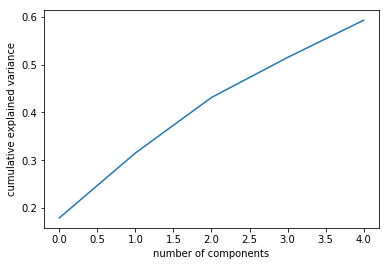

Variance explained for first 5 components in 2012
[17.95646833 31.5197887  43.10851019 51.48047953 59.25120337]



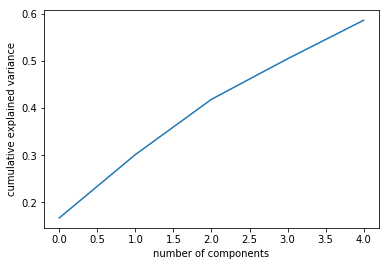

Variance explained for first 5 components in 2013
[16.7143573  30.14266204 41.85783311 50.45376497 58.62272161]



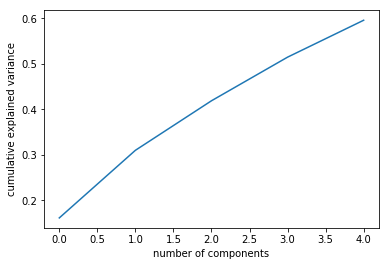

Variance explained for first 5 components in 2014
[16.1609963  31.02178719 41.91270422 51.50116285 59.61521162]



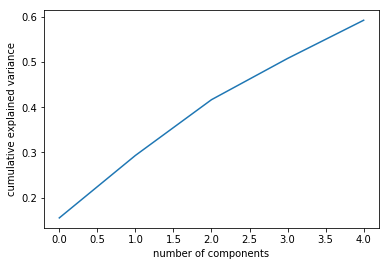

Variance explained for first 5 components in 2015
[15.48367209 29.31424331 41.65909655 50.7932649  59.25316957]



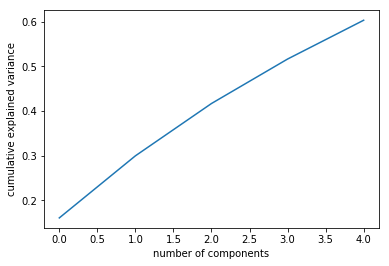

Variance explained for first 5 components in 2016
[16.0483831  29.95605951 41.68143191 51.64258728 60.3369347 ]



In [159]:
pca_dfs = []
for df in dfs:
    pca_df = epc.pca_df(df[0], df[2], df[3], 5, 'entidad', 'year', df[4])
    pca_dfs.append(pca_df)

Across all years, it appears that the first five factors meet the criteria outlined above: individual factors must account for 10% of variance and collectively must account for 60% of variance.

In this instance, the last two factors across all years are close enough to 10% variance and the sum of factors is a little below or a little above 60%.

It also says that eigenvalues must be greater than one, but I don't have a function to show that yet.

#### Rotate Factors

In [160]:
loadings = []
for i in range(len(dfs)):
    loading = epc.factor_loadings(dfs[i][2], dfs[i][0], pca_dfs[i], 'entidad', 'year')
    loadings.append(loading)

In [161]:
loadings[2]

,PC1,PC2,PC3,PC4,PC5
convenios_trabajo_no_juicio,-0.0975996,0.117097,0.155008,-0.6165,0.434661
conflictos_trabajo,0.569319,0.232928,0.487876,-0.250515,0.299418
emplazamientos_huelga,0.554868,-0.0891148,0.133206,0.505685,-0.173853
emplazamientos_huelga_solucionados,0.384138,0.0621664,0.141827,0.566253,-0.120976
huelgas_estalladas,0.465238,0.45661,-0.0688144,0.374949,-0.27381
huelgas_locales_solucionadas,0.436713,0.521734,0.0509153,0.400977,-0.157894
denuncias_total,0.73826,0.489759,0.156798,-0.158991,-0.058932
denuncias_salud,0.642265,0.490815,0.190882,-0.228579,0.032968
denuncias_arma,0.367312,0.666332,0.0244169,0.0396724,0.141106
denuncias_bancaria,0.513263,0.20549,0.219928,0.287135,0.213168
